![picture of Boston skyline from the Charles River](https://images.unsplash.com/photo-1560799260-b737af7dd0fc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2462&q=80)
_Photo by Prateek Pisat on [Unsplash](https://unsplash.com/photos/SFsKWydc7qY)_

# Mapping Boston's Food Scene
Prepared by Brandon Bellanti<br>
Last updated April 25, 2021

---

# Introduction/Business Problem

In my project, I will analyze and cluster food venues across Boston. I'll look at aspects like type of food, price, rating, hours, and location.

Some of the questions I'm interested in answering are:

* Are restaurants of a given food type distrubuted evenly across the city, or are they clustered together? If they're clustered, is there a correlation between the type of food and the demographics of that neighborhood?
* Which neighborhoods in Boston are the most similar in terms of food venues? Which neighborhoods are most different? 
* Does average food venue price correspond with income, either per-capita or by household?

The audience for this analysis is anyone interested in exploring Boston's food scene. One practical way it could be used is by someone who wants to open a restaurant in Boston: they would be able to see where similar restaurants – their competition – already exist or perhaps do not exist.

---
# Data

My data will come from two main sources, Boston's open data hub – [Analyze Boston](https://data.boston.gov/) – and the Foursquare API.

I'll use datasets available on Analyze Boston for [neighborhood](http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.csv) and possibly [demographic data](https://data.boston.gov/dataset/neighborhood-demographics/resource/d8c23c6a-b868-4ba4-8a3b-b9615a21be07?view_id=875bddaa-ffb9-4eaa-bdb5-1b77b414182b) like income or mobility.

I'll use the Foursquare API for venue data. Once I have coordinate data for each Boston neighborhood (returned using the geopy library and the neighborhood data from Analyze Boston), I will call the `/venues` endpoint of the Foursquare API and search for nearby venues that have the categoryId `Food` (4d4b7105d754a06374d81259).

Searching by categoryId also includes all venues in child categories and their children, so I will group the venues by common parent categories to have fewer values overall. Since the results of the standard `/venues` endpoint does not contain parent category information, I'll build a separate reference dataframe with the hierarchy on the Foursquare API [Venue Categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/) page. 

For each venue, I am interested in details such as price and rating, as well as opening hours and popular times. These details are accessed through a Premium endpoint - `/venues/VENUE_ID` – and I am limited to 500 Premium calls per day, so I will store the returned data to CSV files for each neighborhood if I hit my premium call limit. This way, if necessary, I can build a small cache of data over a couple of days and collect all the data I need.

I will use the K-Nearest-Neighbor algorithm to cluster the venues.

---
# Methodology

## Load libraries and credentials

In [1]:
# import libraries
import pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')
# sns.set_theme(style="whitegrid")
import seaborn as sns
import json
import requests
import folium # map rendering library

from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
# API credentials for the Foursquare API

CLIENT_ID = 'PHPYTVIC22RACPESMK2BTWWGZQLEP1H5X4OM5YD3UWPEQ1MN' # your Foursquare ID
CLIENT_SECRET = 'CKKXK00Y4X4IEBXB0BXABSPIQWRTTXG0CLII4E1RRNVU4ZMN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET: ' + CLIENT_SECRET)

## Collect data

### Coordinates for Boston neighborhoods

The City of Boston publishes quite a bit of data publicly through the **Analyze Boston** website ([data.boston.gov](https://data.boston.gov/)). I used the `read_csv()` method in Pandas to build a dataframe from their [Boston Neighborhoods](https://data.boston.gov/dataset/boston-neighborhoods1) dataset, dropping the series I didn't need.

In [3]:
url = 'http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.csv'
neighborhoods_df = pd.read_csv(url)
neighborhoods_df.drop(columns=['ShapeSTArea','ShapeSTLength'],inplace=True)
neighborhoods_df.head()

,OBJECTID,Name,Acres,Neighborhood_ID,SqMiles
0,27,Roslindale,1605.568237,15,2.51
1,28,Jamaica Plain,2519.245394,11,3.94
2,29,Mission Hill,350.853564,13,0.55
3,30,Longwood,188.611947,28,0.29
4,31,Bay Village,26.539839,33,0.04


In [4]:
# print numbered list of Boston neighborhoods
neighborhoods = neighborhoods_df['Name'].unique()
for i,neighborhood in enumerate(sorted(neighborhoods),1):
    print(f"{i})",neighborhood)

1) Allston
2) Back Bay
3) Bay Village
4) Beacon Hill
5) Brighton
6) Charlestown
7) Chinatown
8) Dorchester
9) Downtown
10) East Boston
11) Fenway
12) Harbor Islands
13) Hyde Park
14) Jamaica Plain
15) Leather District
16) Longwood
17) Mattapan
18) Mission Hill
19) North End
20) Roslindale
21) Roxbury
22) South Boston
23) South Boston Waterfront
24) South End
25) West End
26) West Roxbury


In [5]:
# create empty series for latitude and longitude
neighborhoods_df[['Lat','Long']] = np.nan

In [6]:
# fetch the coordinates for Boston
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Boston, Massachusetts'
geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)

boston_lat = location.latitude
boston_long = location.longitude

print('The coordinates of {} are {}, {}'.format(address,boston_lat,boston_long))

The coordinates of Boston, Massachusetts are 42.3602534, -71.0582912


In [7]:
# fetch the coordinates for each neighborhood in Boston and add to the dataframe

neighborhoods_df.set_index('Name',inplace=True)

for neighborhood in neighborhoods_df.index:
#     print(neighborhood)
    address = f'{neighborhood}, Boston, Massachusetts'
    geolocator = Nominatim(user_agent="boston_explorer")
    location = geolocator.geocode(address)
    neighborhoods_df.loc[neighborhood,'Lat'] = location.latitude
    neighborhoods_df.loc[neighborhood,'Long'] = location.longitude

neighborhoods_df.reset_index(inplace=True)

neighborhoods_df.head()

,Name,OBJECTID,Acres,Neighborhood_ID,SqMiles,Lat,Long
0,Roslindale,27,1605.568237,15,2.51,42.291209,-71.124497
1,Jamaica Plain,28,2519.245394,11,3.94,42.309820,-71.120330
2,Mission Hill,29,350.853564,13,0.55,42.332560,-71.103608
3,Longwood,30,188.611947,28,0.29,42.341533,-71.110155
4,Bay Village,31,26.539839,33,0.04,42.350011,-71.066948


In [144]:
# create map of Boston using latitude and longitude values
map_boston = folium.Map(location=[42.324843,-71.095016], zoom_start=12) # use coordinates for Roxbury, most central

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods_df['Lat'], neighborhoods_df['Long'], neighborhoods_df['Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

### Foursquare API category hierarchy

Building a hierarchy of categories for grouping restaurants by type was much more difficult than I expected.

The child categories are nested in their parent categories, but the depth of the child categories is unknown. So I had to develop a way to recursively loop through the categories, which I did with the `cat_grouper()` function below.

First, I isolated the Food category from the results of the API categories call. I used a list comprehension to take the element whose dictionary value for the key `name` was `Food`.

Then, for each child category of the Food category, I built a flattened list of descendent categories. These lists also contained the original child category, so I took the first value of each list as the name of the subcategory.

For the sake of simplicity, I'm only grouping by the first level of child categories in the Food category. This reduces the number of possible Food subcategories from 357 to 92. This is still a large number, and could be reduced further by manual grouping.

In [9]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
)

results = requests.get(url).json()

In [10]:
# print all top-level categories in the Foursquare API hierarchy
categories = results['response']['categories']

for category in categories:
    print(category['name'])

Arts & Entertainment
College & University
Event
Food
Nightlife Spot
Outdoors & Recreation
Professional & Other Places
Residence
Shop & Service
Travel & Transport


In [11]:
# select food parent category and all descendent categories
food_category = [cat for cat in categories if cat['name']=='Food'][0]

In [12]:
# search recursively through child categories of the food category
# append children to list and add that list to a dictionary

def cat_grouper(category):
    subcategory_list.append(category['name'])
    child_cats = category['categories']
    if len(child_cats)>0:
        for child in child_cats:
            cat_grouper(child)
            
category_dict = {}

for category in food_category['categories']:
    subcategory_list = []
    cat_grouper(category)
    group_name = subcategory_list[0]
    group = subcategory_list[1:]
    category_dict[group_name] = group

In [385]:
# print food venue category hierarchy
for category, subcategories in category_dict.items():
    print(category,f"({len(subcategories)} subcategories)" if subcategories else '')
    if subcategories:
        for subcategory in subcategories:
            print('\t' + subcategory)

Afghan Restaurant 
African Restaurant (2 subcategories)
	Ethiopian Restaurant
	Mauritian Restaurant
American Restaurant (1 subcategories)
	New American Restaurant
Armenian Restaurant 
Asian Restaurant (88 subcategories)
	Burmese Restaurant
	Cambodian Restaurant
	Chinese Restaurant
	Anhui Restaurant
	Beijing Restaurant
	Cantonese Restaurant
	Cha Chaan Teng
	Chinese Aristocrat Restaurant
	Chinese Breakfast Place
	Dim Sum Restaurant
	Dongbei Restaurant
	Fujian Restaurant
	Guizhou Restaurant
	Hainan Restaurant
	Hakka Restaurant
	Henan Restaurant
	Hong Kong Restaurant
	Huaiyang Restaurant
	Hubei Restaurant
	Hunan Restaurant
	Imperial Restaurant
	Jiangsu Restaurant
	Jiangxi Restaurant
	Macanese Restaurant
	Manchu Restaurant
	Peking Duck Restaurant
	Shaanxi Restaurant
	Shandong Restaurant
	Shanghai Restaurant
	Shanxi Restaurant
	Szechuan Restaurant
	Taiwanese Restaurant
	Tianjin Restaurant
	Xinjiang Restaurant
	Yunnan Restaurant
	Zhejiang Restaurant
	Filipino Restaurant
	Himalayan Restaurant


### Venue details

In [77]:
def getNearbyFoodVenues(names, latitudes, longitudes, radius=1000):
    categoryId = '4d4b7105d754a06374d81259' # food category
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                address = v['venue']['location']['address']

            except:
                address = ''
            try:
                city = v['venue']['location']['city']

            except:
                city = ''
                
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            city,
            address,
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['location']['distance'],  
            v['venue']['categories'][0]['name'])])

    # loop through list of venues data and build a datafram
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Name', 
                  'Venue ID',
                  'Venue City',
                  'Venue Address',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Distance', 
                  'Venue Category']
    
    # return dataframe
    return(nearby_venues)

In [78]:
food_venues = getNearbyFoodVenues(names=neighborhoods_df['Name'],
                                   latitudes=neighborhoods_df['Lat'],
                                   longitudes=neighborhoods_df['Long']
                                  )

Roslindale
Jamaica Plain
Mission Hill
Longwood
Bay Village
Leather District
Chinatown
North End
Roxbury
South End
Back Bay
East Boston
Charlestown
West End
Beacon Hill
Downtown
Fenway
Brighton
West Roxbury
Hyde Park
Mattapan
Dorchester
South Boston Waterfront
South Boston
Allston
Harbor Islands


In [80]:
# drop any overlapping search results from nearby neighborhoods based on distance
food_venues = food_venues.sort_values(by='Venue Distance').drop_duplicates('Venue ID')

In [194]:
# print number of food venues after deduplication
print('{} food venues found in Boston'.format(food_venues.shape[0]))

944 food venues found in Boston


In [14]:
# function for finding parent category
def find_parent(category):
    if category in category_dict.keys():
        return category
    else:
        for parent, children in category_dict.items():
            if category in children:
                return parent

In [81]:
# add series for parent categories
food_venues['Category Group'] = food_venues['Venue Category'].apply(find_parent)

In [195]:
# count all cateogories
print(f"Number of categories before grouping: {food_venues['Venue Category'].nunique()}")
print(f"Number of categories after grouping: {food_venues['Category Group'].nunique()}")

Number of categories before grouping: 77
Number of categories after grouping: 51


In [120]:
# write dataframe to file for future reference
path = './data/food_venues.csv'
food_venues.to_csv(path,index=False)

In [11]:
# load dataframe from fole
path = './data/food_venues.csv'
food_venues = pd.read_csv(path)
food_venues.shape

(944, 12)

In [13]:
# divide venues in two groups
fv1 = food_venues[:450]
fv2 = food_venues[450:]

In [14]:
fv1

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Name,Venue ID,Venue City,Venue Address,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Category Group
0,Chinatown,42.351329,-71.062623,Pho Pasteur,4a91e4f7f964a520421c20e3,Boston,682 Washington St,42.351513,-71.062811,25,Noodle House,Asian Restaurant
1,Chinatown,42.351329,-71.062623,My Thai Vegan Cafe,4a79dae9f964a520cde71fe3,Boston,3 Beach St,42.351571,-71.062717,27,Vegetarian / Vegan Restaurant,Vegetarian / Vegan Restaurant
2,Chinatown,42.351329,-71.062623,Spicy World,56bfa4e3cd104c42290fae47,Boston,NaN,42.351513,-71.062382,28,Hotpot Restaurant,Asian Restaurant
3,Leather District,42.352322,-71.057343,Al's South Street Cafe,49c90f9bf964a5202d581fe3,Boston,179 Essex St,42.352113,-71.057139,28,Sandwich Place,Sandwich Place
4,Chinatown,42.351329,-71.062623,Dumpling Cafe,4c7c06403badb1f7ea9f5654,Boston,695 Washington St,42.351260,-71.062994,31,Chinese Restaurant,Asian Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
445,Longwood,42.341533,-71.110155,McDonald's,4c62e4aaedd320a13a06ae29,Boston,340 Longwood Ave,42.338286,-71.106846,452,Fast Food Restaurant,Fast Food Restaurant
446,South Boston Waterfront,42.354752,-71.053178,Granary Tavern,4fdf33bfe4b03622b265d4be,Boston,170 Milk St,42.358774,-71.052340,453,American Restaurant,American Restaurant
447,Dorchester,42.297321,-71.074495,Right Taste Jamaican Restaurant,4f328f5319836c91c7e3b14a,Dorchester Center,128 Harvard St,42.296391,-71.079857,453,Food,NaN
448,South End,42.341310,-71.077230,Mela,4ab0261af964a520396620e3,Boston,578 Tremont St,42.343477,-71.072566,453,Indian Restaurant,Indian Restaurant


In [15]:
def getVenueDetails(venue_ids):
    venues_list = []
    for venue_id in venue_ids:
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

        # make the GET request
        r = requests.get(url).json()['response']
        try:
            v = r.get('venue',{})

            venue_details = [(
                v.get('id',None),
                v.get('name',None),
                v.get('rating',None),
                v.get('ratingSignals',None),
                v.get('price',{}).get('tier',None),
                v.get('price',{}).get('message',None)
            )]

            venues_list.append(venue_details)
        except:
            print(r)


    venue_details = pd.DataFrame([item for venue_details in venues_list for item in venue_details])
    venue_details.columns = [
        'Venue ID',
        'Venue Name',
        'Venue Rating',
        'Venue Rating Signals',
        'Venue Price Tier',
        'Venue Price Message']

    return venue_details

In [16]:
# get details for first half of venue dataset
fv1_details = getVenueDetails(fv1['Venue ID'])
fv1_details.shape

(450, 6)

In [17]:
# write data to file for reference
fv1_details.to_csv('./data/food_venue_details_1.csv')

In [191]:
# get details for first half of venue dataset
fv2_details = getVenueDetails(fv2['Venue ID'])
fv2_details.shape

{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '608ae217082e736a6159af4b'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '608ae217a1b24003786c94d5'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '608ae2178c9997729b9de6c1'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '608ae217e7b33421a8dcef0e'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '608ae217c31c135a60216e43'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '608ae218ff75cb354c754ccd'}, 'response': {}}
{'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '608ae2183aeddb44d22e5a7d'}, '

KeyboardInterrupt: 

In [178]:
# write data to file for reference
fv2_details.to_csv('./data/food_venue_details_2.csv')

In [18]:
# load datasets and combine
fv1_details = pd.read_csv('./data/food_venue_details_1.csv',index_col=0)
fv2_details = pd.read_csv('./data/food_venue_details_2.csv',index_col=0)
fv_details = fv1_details
# fv_details = pd.concat([fv1_details,fv2_details],ignore_index=True)
fv_details.tail()

,Venue ID,Venue Name,Venue Rating,Venue Rating Signals,Venue Price Tier,Venue Price Message
445,4c62e4aaedd320a13a06ae29,McDonald's,5.8,9.0,1.0,Cheap
446,4fdf33bfe4b03622b265d4be,Granary Tavern,7.6,413.0,2.0,Moderate
447,4f328f5319836c91c7e3b14a,Right Taste Jamaican Restaurant,NaN,NaN,NaN,NaN
448,4ab0261af964a520396620e3,Mela,7.9,115.0,2.0,Moderate
449,4e04f68ab3ad8ad6f536c543,Earl of Sandwich,8.1,51.0,1.0,Cheap


In [19]:
food_venues = fv_details.merge(food_venues[['Venue ID',
                                            'Neighborhood',
                                            'Venue Category',
                                            'Category Group',
                                            'Venue Latitude',
                                            'Venue Longitude']],
                               left_on='Venue ID',
                               right_on='Venue ID',
                               how='left')

## Explore data

In [20]:
# venues with the most locations
food_venues['Venue Name'].value_counts().head(10)

Dunkin'                   10
SUBWAY                     5
sweetgreen                 4
Tatte Bakery & Cafe        4
McDonald's                 3
Shabu Zen                  2
B.GOOD                     2
Domino's Pizza             2
Chipotle Mexican Grill     2
Dig Inn                    2
Name: Venue Name, dtype: int64

In [90]:
# create series for multiple locations (boolean)
food_venues['Multiple Locations'] = food_venues.groupby('Venue Name')['Venue Name'].transform('count')>1
food_venues['Multiple Locations'] = food_venues['Multiple Locations'].astype(int)

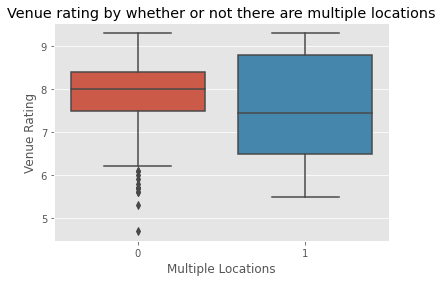

In [91]:
# plot venue rating by multiple locations - box plot
sns.boxplot(x="Multiple Locations", y="Venue Rating", data=food_venues)
plt.title('Venue rating by whether or not there are multiple locations')
plt.show()

In [94]:
food_venues.groupby('Neighborhood')[['Multiple Locations','Venue Rating','Venue Price Tier']].mean()

,Multiple Locations,Venue Rating,Venue Price Tier
Neighborhood,,,
Allston,0.041667,8.237500,1.625000
Back Bay,0.111111,8.237778,2.244444
Bay Village,0.047619,7.966667,2.476190
Beacon Hill,0.047619,7.814286,2.047619
Brighton,0.150000,7.205882,1.400000
Charlestown,0.176471,6.910000,1.500000
Chinatown,0.025641,7.684615,1.513514
Dorchester,0.000000,6.750000,1.166667
Downtown,0.034483,8.137931,2.103448


In [92]:
# food venues multiple locations by neighborhood
grouped = food_venues.groupby('Neighborhood')['Multiple Locations']
grouped.value_counts(normalize=True).to_frame(name='Percentage')

Percentage
Neighborhood            Multiple Locations            
Allston                 0                     0.958333
                        1                     0.041667
Back Bay                0                     0.888889
                        1                     0.111111
Bay Village             0                     0.952381
                        1                     0.047619
Beacon Hill             0                     0.952381
                        1                     0.047619
Brighton                0                     0.850000
                        1                     0.150000
Charlestown             0                     0.823529
                        1                     0.176471
Chinatown               0                     0.974359
                        1                     0.025641
Dorchester              0                     1.000000
Downtown                0                     0.965517
                        1                     0.034483
East Boston             0                     0.812500
                        1                     0.187500
Fenway                  0                     0.869565
                        1                     0.130435
Hyde Park               0                     0.750000
                        1                     0.250000
Jamaica Plain           0                     0.888889
                        1                     0.111111
Leather District        0                     0.888889
                        1                     0.111111
Longwood                0                     0.500000
                        1                     0.500000
Mission Hill            0                     0.904762
                        1                     0.095238
North End               0                     0.982759
                        1                     0.017241
Roslindale              0                     0.750000
                        1                     0.250000
Roxbury                 0                     1.000000
South Boston            0                     1.000000
South Boston Waterfront 0                     1.000000
South End               0                     0.947368
                        1                     0.052632
West End                0                     1.000000

In [79]:
# venues in each neighborhood
food_venues['Neighborhood'].value_counts().sort_index()

Allston                    24
Back Bay                   45
Bay Village                21
Beacon Hill                21
Brighton                   20
Charlestown                17
Chinatown                  39
Dorchester                  7
Downtown                   29
East Boston                16
Fenway                     23
Hyde Park                  12
Jamaica Plain               9
Leather District           18
Longwood                   10
Mission Hill               21
North End                  58
Roslindale                  4
Roxbury                     1
South Boston               16
South Boston Waterfront    14
South End                  19
West End                    6
Name: Neighborhood, dtype: int64

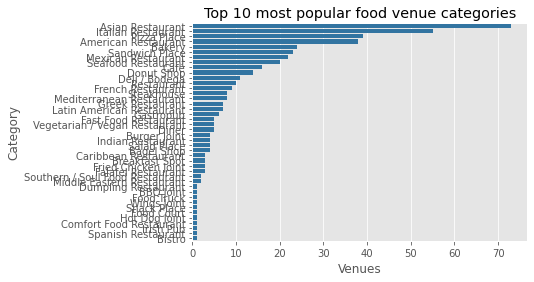

In [23]:
frequent_venues = food_venues['Category Group'].value_counts().reset_index().rename(columns={'index':'Category','Category Group':'Venues'})
sns.barplot(data=frequent_venues,x='Venues',y='Category',color='tab:blue')
plt.title('Top 10 most popular food venue categories')
plt.show()

### Question: What are the most common food venue types? 

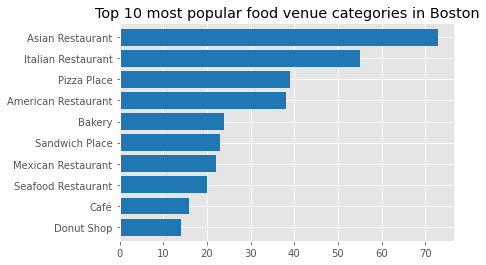

In [145]:
# most popular food venues types
food_venues['Category Group'].value_counts().head(10).sort_values(ascending=True).plot.barh(width=.8,color='tab:blue')
plt.title('Top 10 most popular food venue categories in Boston')
plt.show()

**Answer:** The most common restaurant type in Boston is Asian Restaurant, followed by Italian Restaurant, Pizza Place, and American Restaurant. 

*Remember from before, the Asian Restaurant category in the Foursquare category hierarchy has the most subcategories (88), so from one perspective, it makes sense that it is the most frequent category grouping in this dataset. If the Pizza Place category was grouped with the Italian Restaurant category rather than remain distinct, it would be the most frequent category.*

### Question: What is the distribution of the venue ratings?

<AxesSubplot:xlabel='Venue Rating', ylabel='Count'>

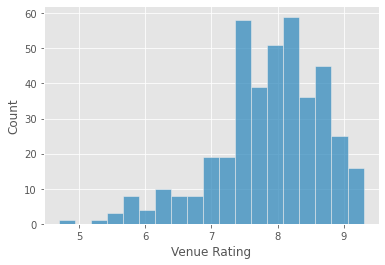

In [25]:
sns.histplot(food_venues,x='Venue Rating')

### Question: How many venues are there in each price category?

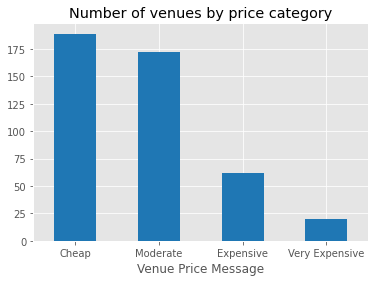

In [143]:
food_venues.value_counts('Venue Price Message').plot.bar(color='tab:blue')
plt.title('Number of venues by price category')
plt.xticks(rotation=0)
plt.show()

**Answer:** Most venues are in the `Cheap` or `Moderate` price categories, with relatively few in the `Very Expensive` category

### Question: Does venue rating correspond with price?

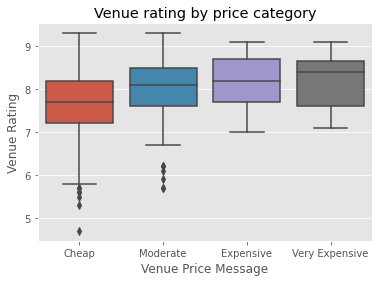

In [26]:
# plot venue rating by price - box plot
sns.boxplot(x="Venue Price Message", y="Venue Rating", data=food_venues)
plt.title('Venue rating by price category')
plt.show()

**Answer:** The median rating increases as the price tier increases.

Another way to look at this relationship between price and rating is through a regression line.

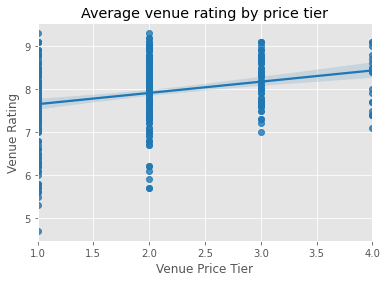

In [35]:
# plot venue rating by price - regplot
sns.regplot(data=food_venues,x='Venue Price Tier', y='Venue Rating',color='tab:blue')
plt.title('Average venue rating by price tier')
plt.show()

**Result:** There is a positive correlation between a venue's price tier and the average rating.

### Question: Does average venue price correspond with per capita income by neighborhood?

In [194]:
income_path = "./data/boston_demographics/income.csv"
income_df = pd.read_csv(income_path)
income_df = income_df.drop(columns='Total Households').set_index('Neighborhood')
income_df.head()

,Mean Per Capita Income,Median Household Income,Median Family Income
Neighborhood,,,
Allston,"$34,149","$58,141","$73,975"
Back Bay,"$110,677","$111,185","$197,348"
Beacon Hill,"$100,005","$110,841","$205,960"
Brighton,"$41,261","$77,625","$92,364"
Charlestown,"$75,339","$127,400","$162,386"


In [195]:
def currency_formatter(string):
    string = string.strip().replace('$','').replace(',','')
    return float(string)

for col in ['Mean Per Capita Income','Median Household Income','Median Family Income']:
    income_df[col]=income_df[col].apply(currency_formatter)

In [148]:
# bin neighborhoods by per capita income
nbins = 8
pd.cut(income_df['Mean Per Capita Income'], bins=nbins, labels=list(range(nbins)))

Neighborhood
Allston                    1
Back Bay                   6
Beacon Hill                6
Brighton                   2
Charlestown                4
Dorchester                 1
Downtown                   4
East Boston                1
Fenway                     1
Hyde Park                  1
Jamaica Plain              2
Longwood                   0
Mattapan                   1
Mission Hill               1
North End                  5
Roslindale                 2
Roxbury                    0
South Boston               3
South Boston Waterfront    7
South End                  4
West End                   4
West Roxbury               2
Name: Mean Per Capita Income, dtype: category
Categories (8, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]

In [196]:
# mean venue price tier by neighborhood
neighborhood_mean_price = food_venues.groupby('Neighborhood')['Venue Price Tier'].mean()

In [197]:
# combine mean venue price tier and income data
price_income = pd.concat([neighborhood_mean_price,income_df],axis=1)

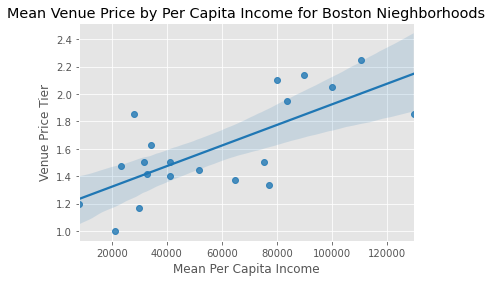

In [281]:
# plot mean per capita income and mean venue price tier
sns.regplot(data=price_income, y='Venue Price Tier',x='Mean Per Capita Income',color='tab:blue')
plt.title('Mean Venue Price by Per Capita Income for Boston Nieghborhoods')
plt.show()

**Answer:** Yes, there is a positive correlation between mean per capita income by neighborhood and mean venue price.

### Question: Is there a relationship betwen venue rating or price and restaurant density (by area or by population)

In [282]:
pop_path = "./data/boston_demographics/race.csv"
pop_df = pd.read_csv(pop_path)
pop_df = pop_df[['Neighborhood','Total Population']]
pop_df['Total Population'] = pop_df['Total Population'].str.replace(',','').astype(int)
pop_df.set_index('Neighborhood',inplace=True)
pop_df.head()

,Total Population
Neighborhood,
Allston,19261
Back Bay,17783
Beacon Hill,9648
Brighton,55297
Charlestown,19890


In [220]:
neighborhood_venues = food_venues.value_counts('Neighborhood').to_frame(name='Venues')
neighborhood_venues.head()

,Venues
Neighborhood,
North End,58
Back Bay,45
Chinatown,39
Downtown,29
Allston,24


In [252]:
density_df = pd.concat([pop_df,neighborhoods_df.set_index('Name')['SqMiles'], neighborhood_venues],axis=1)
density_df.head()

,Total Population,SqMiles,Venues
Allston,19261.0,1.56,24.0
Back Bay,17783.0,0.62,45.0
Beacon Hill,9648.0,0.31,21.0
Brighton,55297.0,2.88,20.0
Charlestown,19890.0,1.36,17.0


In [253]:
# add column for venues per capita
density_df['Venues Per Capita'] = density_df['Venues'] / density_df['Total Population']
# add column for venues per square mile
density_df['Venues Per Sq Mi'] = density_df['Venues'] / density_df['SqMiles']
# add column for mean rating by neighborhood
density_df.insert(0,'Mean Rating',value=food_venues.groupby('Neighborhood')['Venue Rating'].mean())
# add column for mean price by neighborhood
density_df.insert(0,'Mean Price',value=food_venues.groupby('Neighborhood')['Venue Price Tier'].mean())

density_df.head()

In [266]:
density_df.corr().style.background_gradient()

,Mean Price,Mean Rating,Total Population,SqMiles,Venues,Venues Per Capita,Venues Per Sq Mi
Mean Price,1.000000,0.731019,-0.479287,-0.551916,0.645470,0.623991,0.353052
Mean Rating,0.731019,1.000000,-0.473851,-0.605576,0.502264,0.502785,0.367577
Total Population,-0.479287,-0.473851,1.000000,0.825631,-0.352206,-0.516766,-0.348042
SqMiles,-0.551916,-0.605576,0.825631,1.000000,-0.473543,-0.539796,-0.415819
Venues,0.645470,0.502264,-0.352206,-0.473543,1.000000,0.783450,0.292833
Venues Per Capita,0.623991,0.502785,-0.516766,-0.539796,0.783450,1.000000,0.909560
Venues Per Sq Mi,0.353052,0.367577,-0.348042,-0.415819,0.292833,0.909560,1.000000


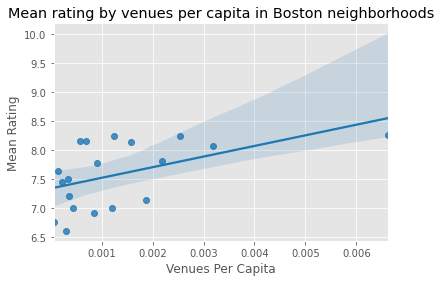

In [273]:
sns.regplot(data=density_df, x='Venues Per Capita',y='Mean Rating',color='tab:blue')
plt.title('Mean rating by venues per capita in Boston neighborhoods')
plt.show()

**Answer:** There is weak correlation between venues per capita and mean price/rating by neighborhood. However, this may not be strong enough to include in the final feature set.

In [276]:
# average price tier by neighborhood
food_venues.groupby('Neighborhood')['Venue Price Tier'].mean().to_frame().style.background_gradient()

,Venue Price Tier
Neighborhood,
Allston,1.625000
Back Bay,2.244444
Bay Village,2.476190
Beacon Hill,2.047619
Brighton,1.400000
Charlestown,1.500000
Chinatown,1.513514
Dorchester,1.166667
Downtown,2.103448


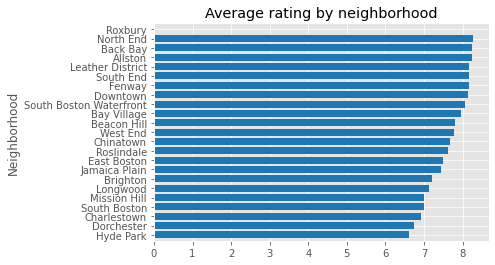

In [32]:
# average rating by neighborhood
food_venues.groupby('Neighborhood')['Venue Rating'].mean().sort_values().plot.barh(color='tab:blue',width=.75)
plt.title('Average rating by neighborhood')
plt.show()

In [33]:
# average rating and price tier for each category group
food_venues.groupby('Category Group')[['Venue Rating','Venue Price Tier']].mean()

,Venue Rating,Venue Price Tier
Category Group,,
American Restaurant,7.777143,2.263158
Asian Restaurant,7.646269,1.757143
BBQ Joint,8.900000,3.000000
Bagel Shop,7.550000,1.250000
Bakery,8.100000,1.166667
Bistro,8.000000,2.000000
Breakfast Spot,8.100000,1.333333
Burger Joint,7.800000,1.250000
Café,7.890000,1.000000


## Clustering food venues in Boston

In [369]:
category_dummies = pd.get_dummies(food_venues['Category Group'])
category_dummies['Neighborhood']=food_venues['Neighborhood']

In [406]:
neighborhoods_grouped = category_dummies.groupby('Neighborhood').mean()

In [407]:
neighborhoods_grouped

,American Restaurant,Asian Restaurant,Bakery,Café,Deli / Bodega,Donut Shop,Italian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Pizza Place,Sandwich Place,Seafood Restaurant,Vegetarian / Vegan Restaurant
Neighborhood,,,,,,,,,,,,,
Back Bay,0.666667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000
Brighton,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
Chinatown,0.000000,0.666667,0.111111,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.000000,0.111111
Downtown,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000
East Boston,0.000000,0.000000,0.000000,0.000000,0.0,0.5,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.000000
Hyde Park,0.333333,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.000000,0.000000
Leather District,0.000000,0.333333,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.000000
North End,0.000000,0.000000,0.166667,0.083333,0.0,0.0,0.5,0.0,0.0,0.166667,0.000000,0.083333,0.000000
South End,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [412]:
price_dummies = pd.get_dummies(food_venues['Venue Price Message'])
price_dummies['Neighborhood'] = food_venues['Neighborhood']

In [413]:
price_dummies.groupby('Neighborhood').mean()

,Cheap,Expensive,Moderate,Very Expensive
Neighborhood,,,,
Back Bay,0.333333,0.333333,0.333333,0.000000
Brighton,0.000000,0.000000,1.000000,0.000000
Chinatown,0.666667,0.000000,0.333333,0.000000
Downtown,1.000000,0.000000,0.000000,0.000000
East Boston,1.000000,0.000000,0.000000,0.000000
Hyde Park,0.666667,0.000000,0.333333,0.000000
Leather District,0.666667,0.000000,0.000000,0.333333
North End,0.250000,0.250000,0.500000,0.000000
South End,1.000000,0.000000,0.000000,0.000000


In [420]:
nbins = 3
food_venues['Rating Bins'] = pd.cut(food_venues['Venue Rating'], bins=nbins, labels=['Low','Medium','High'])
food_venues.drop(columns='Rating Bins')

,Venue ID,Venue Name,Venue Rating,Venue Rating Signals,Venue Price Tier,Venue Price Message,Neighborhood,Venue Category,Category Group
0,4a91e4f7f964a520421c20e3,Pho Pasteur,7.8,432,1,Cheap,Chinatown,Noodle House,Asian Restaurant
1,4a79dae9f964a520cde71fe3,My Thai Vegan Cafe,7.6,206,2,Moderate,Chinatown,Vegetarian / Vegan Restaurant,Vegetarian / Vegan Restaurant
2,49c90f9bf964a5202d581fe3,Al's South Street Cafe,7.6,135,1,Cheap,Leather District,Sandwich Place,Sandwich Place
3,4c7c06403badb1f7ea9f5654,Dumpling Cafe,7.6,341,1,Cheap,Chinatown,Chinese Restaurant,Asian Restaurant
4,4aaacac0f964a5206e5720e3,New Saigon Sandwich,7.4,34,2,Moderate,Chinatown,Asian Restaurant,Asian Restaurant
5,4c91546ab641236ab6a68079,Q Restaurant,8.2,281,2,Moderate,Chinatown,Hotpot Restaurant,Asian Restaurant
6,4c29032ace3fc928e6156e88,SUBWAY,6.4,5,1,Cheap,Hyde Park,Sandwich Place,Sandwich Place
7,4e4be732e4cde30b72898e6d,Irashai Sushi Teriyaki,7.4,103,1,Cheap,Chinatown,Sushi Restaurant,Asian Restaurant
8,4ab90e73f964a520dd7d20e3,Mei Sum Bakery,7.6,19,1,Cheap,Chinatown,Bakery,Bakery
9,59a5e22265cdf802902711fd,Boston Pocket Deli,8.4,38,1,Cheap,South End,Deli / Bodega,Deli / Bodega


In [440]:
features = food_venues[['Venue Rating','Venue Price Tier']]
X = features.merge(category_dummies,left_index=True,right_index=True).drop(columns='Neighborhood')
X = preprocessing.StandardScaler().fit(X).transform(X)
X

array([[ 0.04952246, -0.83305216, -0.29704426,  1.90394328, -0.34815531,
        -0.16666667, -0.16666667, -0.16666667, -0.43994135, -0.16666667,
        -0.16666667, -0.43994135, -0.29704426, -0.16666667, -0.16666667],
       [-0.23237463,  0.45123659, -0.29704426, -0.52522573, -0.34815531,
        -0.16666667, -0.16666667, -0.16666667, -0.43994135, -0.16666667,
        -0.16666667, -0.43994135, -0.29704426, -0.16666667,  6.        ],
       [-0.23237463, -0.83305216, -0.29704426, -0.52522573, -0.34815531,
        -0.16666667, -0.16666667, -0.16666667, -0.43994135, -0.16666667,
        -0.16666667, -0.43994135,  3.36650165, -0.16666667, -0.16666667],
       [-0.23237463, -0.83305216, -0.29704426,  1.90394328, -0.34815531,
        -0.16666667, -0.16666667, -0.16666667, -0.43994135, -0.16666667,
        -0.16666667, -0.43994135, -0.29704426, -0.16666667, -0.16666667],
       [-0.51427172,  0.45123659, -0.29704426,  1.90394328, -0.34815531,
        -0.16666667, -0.16666667, -0.16666667, 

In [444]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(X)
kmeans.labels_

array([4, 4, 2, 4, 4, 4, 2, 4, 0, 4, 1, 4, 4, 4, 1, 3, 2, 0, 4, 3, 0, 3,
       1, 3, 3, 1, 4, 4, 1, 4, 3, 1, 3, 0, 4, 3, 4], dtype=int32)

In [447]:
food_venues.insert(0,'Cluster',kmeans.labels_)

ValueError: cannot insert Cluster, already exists

In [451]:
food_venues.groupby('Cluster').agg(['mean','count'])

Venue Rating       Venue Rating Signals       Venue Price Tier      
                mean count                 mean count             mean count
Cluster                                                                     
0           8.325000     4           105.750000     4         1.250000     4
1           7.816667     6            56.000000     6         1.333333     6
2           6.833333     3            48.333333     3         1.000000     3
3           8.112500     8           225.000000     8         2.750000     8
4           7.606250    16           154.875000    16         1.437500    16

---
# Results

---
# Discussion

---
# Conclusion